In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
season_results = pd.read_csv("MRegularSeasonDetailedResults.csv")
all_teams = pd.read_csv("MTeams.csv")
playoffs_results = pd.read_csv("MNCAATourneyDetailedResults.csv")
pd.set_option('display.max_columns', None)

In [3]:
# playoffs_2014 = playoffs_results[playoffs_results['Season'] == 2014]
# team_ids = pd.concat([playoffs_2014['WTeamID'], playoffs_2014['LTeamID']]).unique()
# teams = teams[teams['TeamID'].isin(team_ids)]
individual_team_data = all_teams[['TeamID','TeamName']]

In [4]:
new_columns = ['3FG', 'APG', 'AST', 'BKPG', 'BLKS', 'BPI', 'FGM', 'FGA', 'FT', 'L', 'REB', 'RPG', 'RPI', 'PTS', 'ST', 'STPG', 'TO', 'W', 
               'WPRC', 'FGPRC','GPlayed']  

for col in new_columns:
    individual_team_data[col] = 0 

sr_tmp = season_results[(season_results['Season'] >= 2011) & (season_results['Season'] <= 2014)]

for team in individual_team_data['TeamID']:
    
    win_rows = sr_tmp[sr_tmp['WTeamID'] == team]
    
    individual_team_data.loc[individual_team_data['TeamID'] == team, '3FG'] += win_rows['WFGM3'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'AST'] += win_rows['WAst'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'BLKS'] += win_rows['WBlk'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'FGM'] += win_rows['WFGM'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'FGA'] += win_rows['WFGA'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'FT'] += win_rows['WFTM'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'REB'] += (win_rows['WOR'] + win_rows['WDR']).sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'PTS'] += win_rows['WScore'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'ST'] += win_rows['WStl'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'TO'] += win_rows['WTO'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'W'] += win_rows.shape[0]
    
    lose_rows = sr_tmp[sr_tmp['LTeamID'] == team]
    
    individual_team_data.loc[individual_team_data['TeamID'] == team, '3FG'] += lose_rows['LFGM3'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'AST'] += lose_rows['LAst'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'BLKS'] += lose_rows['LBlk'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'FGM'] += lose_rows['LFGM'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'FGA'] += lose_rows['LFGA'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'FT'] += lose_rows['LFTM'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'REB'] += (lose_rows['LOR'] + lose_rows['LDR']).sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'PTS'] += lose_rows['LScore'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'ST'] += lose_rows['LStl'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'TO'] += lose_rows['LTO'].sum()
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'L'] += lose_rows.shape[0]  
    
    individual_team_data.loc[individual_team_data['TeamID'] == team, 'GPlayed'] += win_rows.shape[0] + lose_rows.shape[0]

individual_team_data = individual_team_data[individual_team_data['GPlayed'] != 0]    

individual_team_data['APG'] = individual_team_data['AST'] / individual_team_data['GPlayed']
individual_team_data['BKPG'] = individual_team_data['BLKS'] / individual_team_data['GPlayed']
individual_team_data['RPG'] = individual_team_data['REB'] / individual_team_data['GPlayed']
individual_team_data['STPG'] = individual_team_data['ST'] / individual_team_data['GPlayed']
individual_team_data['FGPRC'] = individual_team_data['FGM'] / individual_team_data['FGA']
individual_team_data['WPRC'] = individual_team_data['W'] / individual_team_data['GPlayed']

opponents_winning_percentage = individual_team_data['WPRC'].mean()

individual_team_data['RPI'] = 0.25 * individual_team_data['WPRC'] + 0.75 * opponents_winning_percentage
individual_team_data['RPIrank'] = individual_team_data['RPI'].rank(ascending=False, method='min')


individual_team_data

,TeamID,TeamName,3FG,APG,AST,BKPG,BLKS,BPI,FGM,FGA,FT,L,REB,RPG,RPI,PTS,ST,STPG,TO,W,WPRC,FGPRC,GPlayed,RPIrank
0,1101,Abilene Chr,140,10.000000,210,1.476190,31,0,427,1053,332,19,595,28.333333,0.393051,1326,121,5.761905,315,2,0.095238,0.405508,21,351.0
1,1102,Air Force,789,14.432432,1602,2.540541,282,0,2493,5510,1400,61,3249,29.270270,0.481855,7175,665,5.990991,1396,50,0.450450,0.452450,111,205.0
2,1103,Akron,906,13.538462,1760,4.353846,566,0,3215,7250,1801,41,4612,35.476923,0.540396,9137,892,6.861538,1730,89,0.684615,0.443448,130,40.0
3,1104,Alabama,614,11.488189,1459,4.519685,574,0,2970,6735,1728,53,4343,34.196850,0.514911,8282,1002,7.889764,1634,74,0.582677,0.440980,127,107.0
4,1105,Alabama A&M,555,11.546296,1247,4.138889,447,0,2357,5896,1463,72,3750,34.722222,0.452575,6732,702,6.500000,1602,36,0.333333,0.399763,108,296.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
359,1460,Wright St,772,11.285714,1422,1.904762,240,0,2683,6278,1731,59,3595,28.531746,0.502178,7869,849,6.738095,1600,67,0.531746,0.427365,126,143.0
360,1461,Wyoming,684,11.355932,1340,3.516949,415,0,2542,5762,1656,59,3459,29.313559,0.494242,7424,728,6.169492,1388,59,0.500000,0.441166,118,167.0
361,1462,Xavier,644,13.226562,1693,3.148438,403,0,3160,6857,2027,45,4576,35.750000,0.531351,8991,729,5.695312,1601,83,0.648438,0.460843,128,57.0
362,1463,Yale,592,11.926606,1300,3.816514,416,0,2388,5667,1828,52,3783,34.706422,0.499976,7196,602,5.522936,1504,57,0.522936,0.421387,109,151.0


Pojedinačna statistika za svaku ekipu koja je odigrala utakmicu u sezonama od 2011 do 2014.

In [5]:
teams = individual_team_data['TeamID'].tolist()
checked_teams = []

results = []

for team_id in teams:
    team_games = sr_tmp[(sr_tmp['WTeamID'] == team_id) | (sr_tmp['LTeamID'] == team_id)]

    for index, game in team_games.iterrows():
        w_team_id = game['WTeamID']
        l_team_id = game['LTeamID']

        if w_team_id in checked_teams or l_team_id in checked_teams:
            continue

        w_team_rpi = individual_team_data.loc[individual_team_data['TeamID'] == w_team_id].iloc[0]
        l_team_rpi = individual_team_data.loc[individual_team_data['TeamID'] == l_team_id].iloc[0]

        if team_id == w_team_id:
            won = 1
            diff_steals = game['WAst'] - game['LAst']
            diff_assists = game['WStl'] - game['LStl']
            diff_blocks = game['WBlk'] - game['LBlk']
            diff_fgprc = game['WFGM']/game['WFGA'] - game['LFGM']/game['LFGA']
            diff_pts = w_team_rpi['PTS'] - l_team_rpi['PTS']
            diff_rpi = w_team_rpi['RPI'] - l_team_rpi['RPI']
            diff_rpirank = w_team_rpi['RPIrank'] - l_team_rpi['RPIrank']
        else:
            won = 0
            diff_steals = game['LAst'] - game['WAst']
            diff_assists = game['LStl'] - game['WStl']
            diff_blocks = game['LBlk'] - game['WBlk']
            diff_pts = l_team_rpi['PTS'] - w_team_rpi['PTS']
            diff_fgprc = game['LFGM']/game['LFGA'] - game['WFGM']/game['WFGA']
            diff_rpi = l_team_rpi['RPI'] - w_team_rpi['RPI']
            diff_rpirank = l_team_rpi['RPIrank'] - w_team_rpi['RPIrank']

        results.append({
            'StlDiff': diff_steals,
            'AstDiff': diff_assists,
            'BlkDiff': diff_blocks,
            'PtsDiff': diff_pts,
            'FGPrcDiff': diff_fgprc,
            'RPIDiff': diff_rpi,
            'RPIrankDiff': diff_rpirank,
            'Won': won
        })

    checked_teams.extend([team_id])


training_data = pd.DataFrame(results)
training_data

,StlDiff,AstDiff,BlkDiff,PtsDiff,FGPrcDiff,RPIDiff,RPIrankDiff,Won
0,-10,-1,-1,-7279,-0.168035,-0.087535,141.0,0
1,-8,-5,-6,-7497,-0.096429,-0.114402,228.0,0
2,-3,-3,-10,-8100,-0.175751,-0.119320,237.0,0
3,-19,-8,-5,-8078,-0.363692,-0.109911,209.0,0
4,2,-3,-1,-6595,-0.078333,-0.066916,72.0,0
...,...,...,...,...,...,...,...,...
21176,-4,4,-8,-140,-0.103175,0.030763,-98.0,0
21177,7,8,-4,-140,0.196581,0.030763,-98.0,1
21178,4,2,0,-140,0.078647,0.030763,-98.0,1
21179,4,-1,-1,-140,0.021739,0.030763,-98.0,0


Razlike statistika dviju ekipa za svaku utakmicu u sezonama od 2011 do 2014. Vrijednost 'Won' je 1 ukoliko je ekipa koju gledamo pobijedila, a 0 inače. Ovo će nam kasnije poslužiti kao skup za treniranje modela.

In [6]:
from itertools import combinations

unique_teams = individual_team_data['TeamName'].unique()

test_data = pd.DataFrame(columns=['Matchup', 'AstDiff', 'StlDiff', 'BlkDiff', 'PtsDiff', 'FGPrcDiff', 'RPIDiff', 'RPIrankDiff'])
for team1, team2 in combinations(unique_teams, 2):
    team1_data = individual_team_data[individual_team_data['TeamName'] == team1]
    team2_data = individual_team_data[individual_team_data['TeamName'] == team2]

    diffs = team1_data[['APG', 'STPG', 'BKPG', 'PTS', 'FGPRC', 'RPI', 'RPIrank']].sum() - team2_data[['APG', 'STPG', 'BKPG', 'PTS', 'FGPRC', 'RPI', 'RPIrank']].sum()

    column_name = f"{team1}_{team2}"

    test_data = pd.concat([test_data, pd.DataFrame({'Matchup': [column_name], 'AstDiff': [diffs['APG']], 'StlDiff': [diffs['STPG']],
                                                   'BlkDiff': [diffs['BKPG']], 'PtsDiff': [diffs['PTS']], 'FGPrcDiff': [diffs['FGPRC']], 
                                                    'RPIDiff': [diffs['RPI']], 'RPIrankDiff': [diffs['RPIrank']]})], ignore_index=True)

    
test_data.to_csv('test_data.csv', index=False)

test_data

,Matchup,AstDiff,StlDiff,BlkDiff,PtsDiff,FGPrcDiff,RPIDiff,RPIrankDiff
0,Abilene Chr_Air Force,-4.432432,-0.229086,-1.064350,-5849.0,-0.046942,-0.088803,146.0
1,Abilene Chr_Akron,-3.538462,-1.099634,-2.877656,-7811.0,-0.037940,-0.147344,311.0
2,Abilene Chr_Alabama,-1.488189,-2.127859,-3.043495,-6956.0,-0.035472,-0.121860,244.0
3,Abilene Chr_Alabama A&M,-1.546296,-0.738095,-2.662698,-5406.0,0.005746,-0.059524,55.0
4,Abilene Chr_Alabama St,-1.575000,-1.146429,-2.132143,-6181.0,0.007854,-0.080357,120.0
...,...,...,...,...,...,...,...,...
61771,Wyoming_Yale,-0.570673,0.646556,-0.299565,228.0,0.019779,-0.005734,16.0
61772,Wyoming_Youngstown St,-2.539720,-0.134856,-0.961312,-585.0,0.010823,0.022826,-74.0
61773,Xavier_Yale,1.299957,0.172377,-0.668076,1795.0,0.039456,0.031375,-94.0
61774,Xavier_Youngstown St,-0.669090,-0.609035,-1.329823,982.0,0.030500,0.059935,-184.0


Svi parovi ekipa, te njihove razlike u statistikama. Ovo će nam poslužiti kao skup za testiranje na kojem ćemo raditi predikcije.

In [27]:
variables = training_data.drop('Won', axis=1).columns.tolist()

def train_on_variable(v):
    X = training_data[[v]]
    y = training_data['Won']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    poly = PolynomialFeatures(degree=2)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.transform(X_test)

    model = LogisticRegression()
    model.fit(X_train_poly, y_train)

    return model, poly

td = pd.read_csv('test_data.csv')
predictions = pd.DataFrame(td['Matchup'])
predictions['Probability'] = 0

for v in variables:
    print(v)
    model, poly = train_on_variable(v)
    
    for index, row in td.iterrows():
        matchup = row['Matchup']
        diff = row[v]

        diff_poly = poly.transform([[diff]])
        predictions.loc[predictions['Matchup'] == matchup, 'Probability'] += model.predict_proba(diff_poly)[:, 1]


predictions['Probability'] /= 7

predictions.to_csv('predictions.csv', index=False)
predictions

StlDiff
AstDiff
BlkDiff
PtsDiff
FGPrcDiff
RPIDiff
RPIrankDiff


,Matchup,Probability
0,Abilene Chr_Air Force,0.279541
1,Abilene Chr_Akron,0.231147
2,Abilene Chr_Alabama,0.242841
3,Abilene Chr_Alabama A&M,0.348766
4,Abilene Chr_Alabama St,0.321820
...,...,...
61771,Wyoming_Yale,0.511356
61772,Wyoming_Youngstown St,0.509982
61773,Xavier_Yale,0.623705
61774,Xavier_Youngstown St,0.615746


Vjerojatnost da će prva ekipa pobijediti drugu ekipu.

In [133]:
predictions[(predictions['Matchup'] == 'Colorado_Pittsburgh')]

,Matchup,Probability
17696,Colorado_Pittsburgh,0.451464


Primjer korištenja za neki par ekipa.

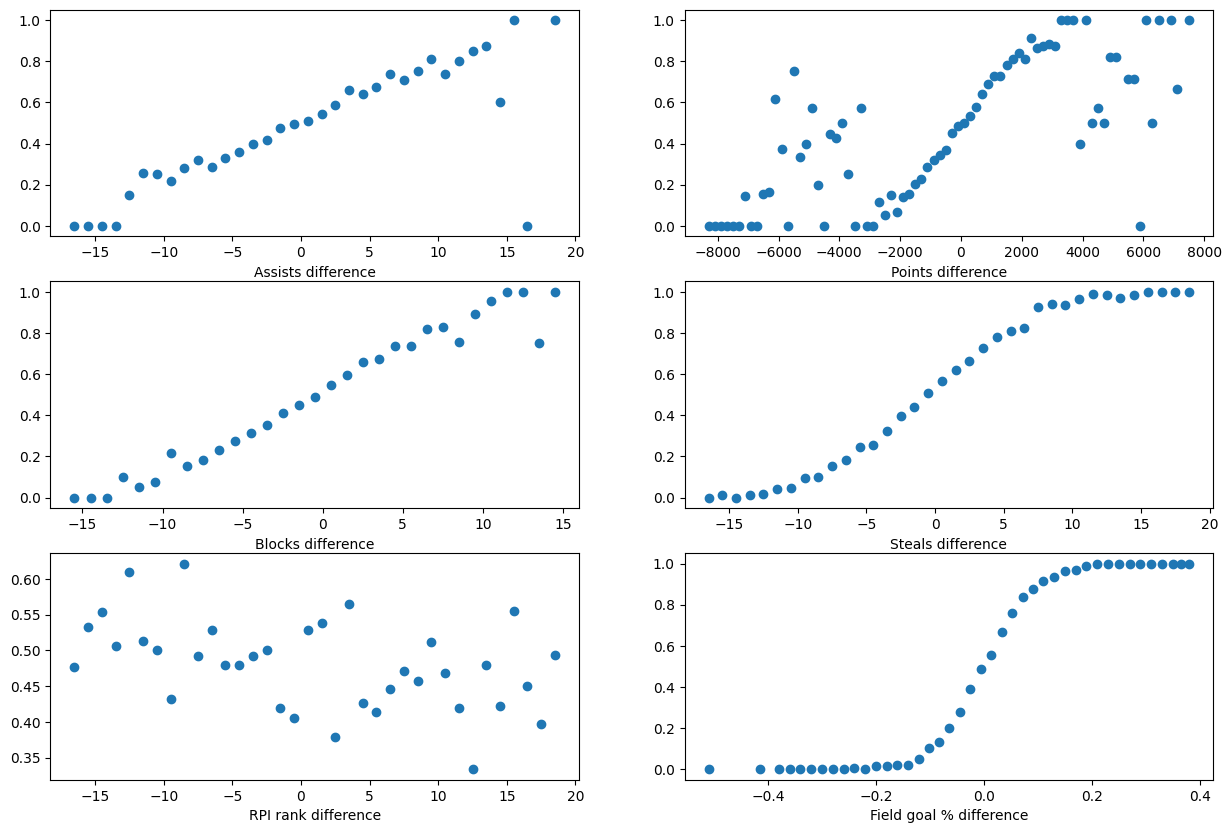

In [131]:
import matplotlib.pyplot as plt

training_data['RPIrankDiff'] = training_data['RPIrankDiff'].astype(int)

ast_bins = range(training_data['AstDiff'].min(), training_data['AstDiff'].max() + 1)
blk_bins = range(training_data['BlkDiff'].min(), training_data['BlkDiff'].max() + 1)
stl_bins = range(training_data['StlDiff'].min(), training_data['StlDiff'].max() + 1)
rpi_bins = range(training_data['RPIrankDiff'].min(), training_data['RPIrankDiff'].max() + 1)
pts_bins = range((training_data['PtsDiff'].min() // 200) * 200, ((training_data['PtsDiff'].max() + 199) // 200) * 200 + 1, 200)

training_data['AstDiffGroup'] = pd.cut(training_data['AstDiff'], bins=ast_bins)
training_data['BlkDiffGroup'] = pd.cut(training_data['BlkDiff'], bins=ast_bins)
training_data['StlDiffGroup'] = pd.cut(training_data['StlDiff'], bins=ast_bins)
training_data['RPIrankDiffGroup'] = pd.cut(training_data['RPIrankDiff'], bins=ast_bins)
training_data['PtsDiffGroup'] = pd.cut(training_data['PtsDiff'], bins=pts_bins)
training_data['FGPrcDiffGroup'] = pd.cut(training_data['FGPrcDiff'], bins=round((training_data['FGPrcDiff'].max() - training_data['FGPrcDiff'].min()) / 0.02) + 1, precision=2)

ast_diff_percentage = training_data.groupby('AstDiffGroup')['Won'].mean() * 100
blk_diff_percentage = training_data.groupby('BlkDiffGroup')['Won'].mean() * 100
stl_diff_percentage = training_data.groupby('StlDiffGroup')['Won'].mean() * 100
rpi_diff_percentage = training_data.groupby('RPIrankDiffGroup')['Won'].mean() * 100
pts_diff_percentage = training_data.groupby('PtsDiffGroup')['Won'].mean() * 100
fgprc_diff_percentage = training_data.groupby('FGPrcDiffGroup')['Won'].mean() * 100

ast_diff_percentage.index = ast_diff_percentage.index.map(lambda x: x.mid)

fig, ax = plt.subplots(3, 2, figsize=(15, 10))
ax[0, 0].scatter(ast_diff_percentage.index, [x/100 for x in ast_diff_percentage.values])
ax[0, 0].set_xlabel('Assists difference')

#x = np.linspace(ast_diff_percentage.index.min(), ast_diff_percentage.index.max())
#model, poly = train_on_variable('AstDiff')
#y = [model.intercept_ + x**2*model.coef_[0][2] + x*model.coef_[0][1] + model.coef_[0][0] for x in x]
#ax[0, 0].plot(x, y)

pts_diff_percentage.index = pts_diff_percentage.index.map(lambda x: x.mid)

ax[0, 1].scatter(pts_diff_percentage.index, [x/100 for x in pts_diff_percentage.values])
ax[0, 1].set_xlabel('Points difference')

blk_diff_percentage.index = blk_diff_percentage.index.map(lambda x: x.mid)

ax[1, 0].scatter(blk_diff_percentage.index, [x/100 for x in blk_diff_percentage.values])
ax[1, 0].set_xlabel('Blocks difference')

stl_diff_percentage.index = stl_diff_percentage.index.map(lambda x: x.mid)

ax[1, 1].scatter(stl_diff_percentage.index, [x/100 for x in stl_diff_percentage.values])
ax[1, 1].set_xlabel('Steals difference')

rpi_diff_percentage.index = rpi_diff_percentage.index.map(lambda x: x.mid)

ax[2, 0].scatter(rpi_diff_percentage.index, [x/100 for x in rpi_diff_percentage.values])
ax[2, 0].set_xlabel('RPI rank difference')

fgprc_diff_percentage.index = fgprc_diff_percentage.index.map(lambda x: x.mid)

ax[2, 1].scatter(fgprc_diff_percentage.index, [x/100 for x in fgprc_diff_percentage.values])
ax[2, 1].set_xlabel('Field goal % difference')

plt.show()


Prikaz koliko često pobjeđuje ekipa s razlikom u određenoj statistici.